<a href="https://colab.research.google.com/github/ostapana/monsters_classification/blob/main/EDA_%2B_training_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir competition

In [ ]:
%cd competition/
!ls

/content/competition


downloading data

In [ ]:
!gdown --id 1AdY6NVXlZOVHpXDMR3osbqiK0uO9ahUB #train
!gdown --id 1cL21_ROCKCRuQzRBv_gziqgTR-1MOwtr #test


Downloading...
From: https://drive.google.com/uc?id=1AdY6NVXlZOVHpXDMR3osbqiK0uO9ahUB
To: /content/competition/train.csv
100% 34.5k/34.5k [00:00<00:00, 1.08MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cL21_ROCKCRuQzRBv_gziqgTR-1MOwtr
To: /content/competition/test.csv
100% 45.7k/45.7k [00:00<00:00, 1.47MB/s]


# Performing EDA

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import svm

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [ ]:
#data types, just in case
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             371 non-null    int64  
 1   bone_length    371 non-null    float64
 2   rotting_flesh  371 non-null    float64
 3   hair_length    371 non-null    float64
 4   has_soul       371 non-null    float64
 5   color          371 non-null    object 
 6   type           371 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


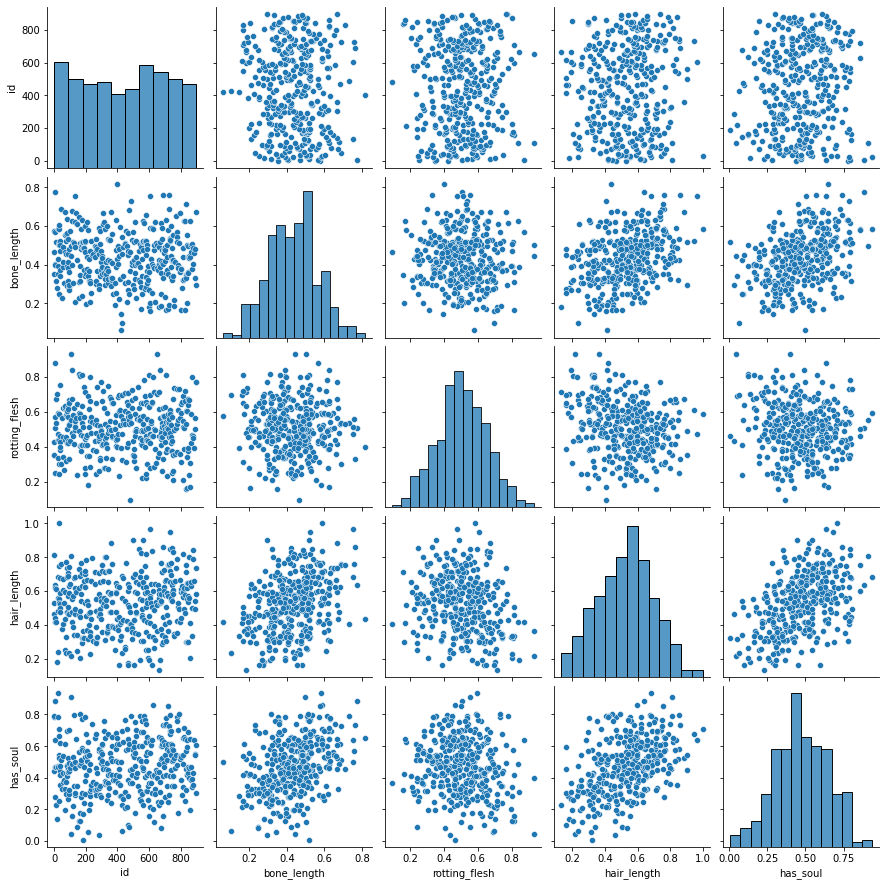

In [ ]:
sns.pairplot(df)
plt.show()

it's obvious that there is not dependancy between different features (except maybe for hair_length and soul, what?)


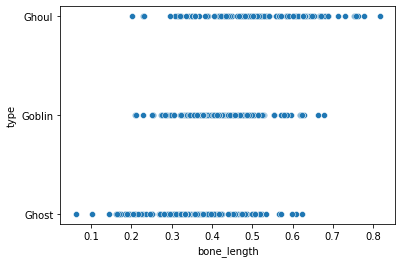

In [ ]:
sns.scatterplot(data=df, x="bone_length", y="type")
#that's better

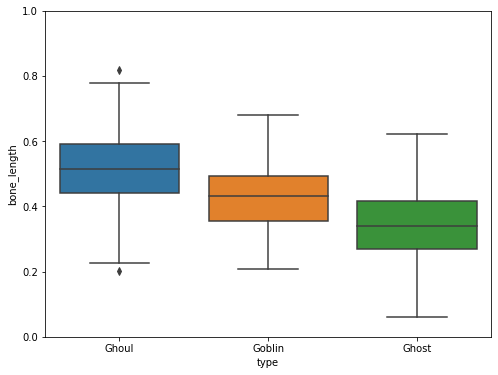

In [ ]:
#a box with mustache
col = 'type'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=col, y="bone_length", data=df[['bone_length', col]])
fig.axis(ymin=0, ymax=1);

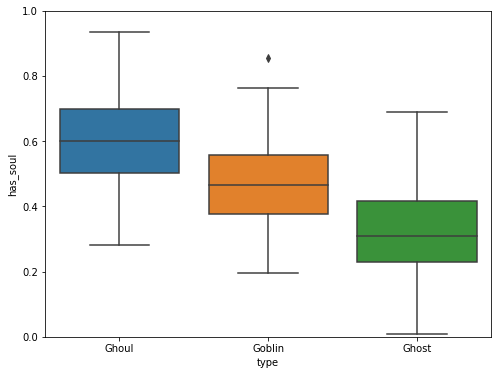

In [ ]:
col = 'type'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=col, y="has_soul", data=df[['has_soul', col]])
fig.axis(ymin=0, ymax=1);

and correlation matrix yuppi

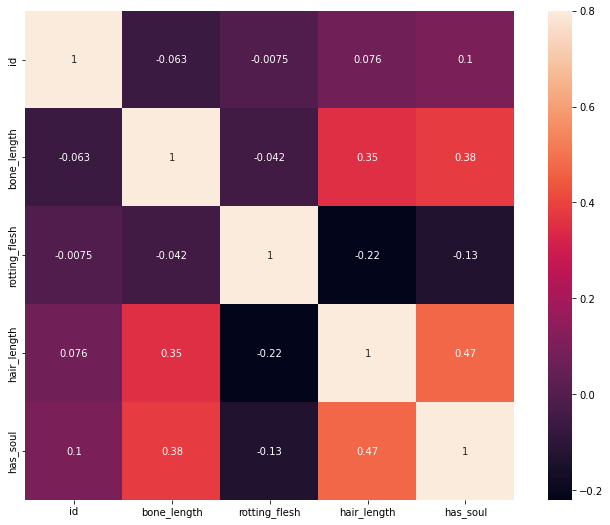

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);
#nothing here (not that I expected anything after all)

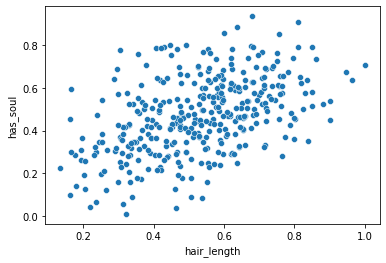

In [ ]:
sns.scatterplot(data=df, x="hair_length", y="has_soul")

I still don't understand the connection between hair length and having a soul, like are those long-haired hippies?

In [ ]:
df.isnull().sum()
#no null values

id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64

I've heard the clusterisation can be done and then added as a feature. So, why not to try

##Cluster analysis

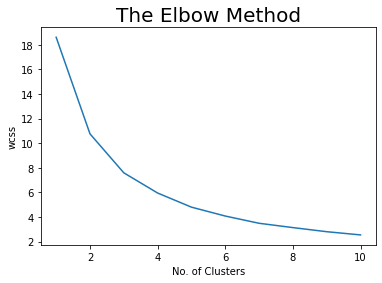

In [ ]:
# elbow method
from sklearn.cluster import KMeans

x = df.loc[:, ['rotting_flesh', 'hair_length']].values

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(x)
    wcss.append(km.inertia_)

# show the ratio of the criterion to the number of clusters
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

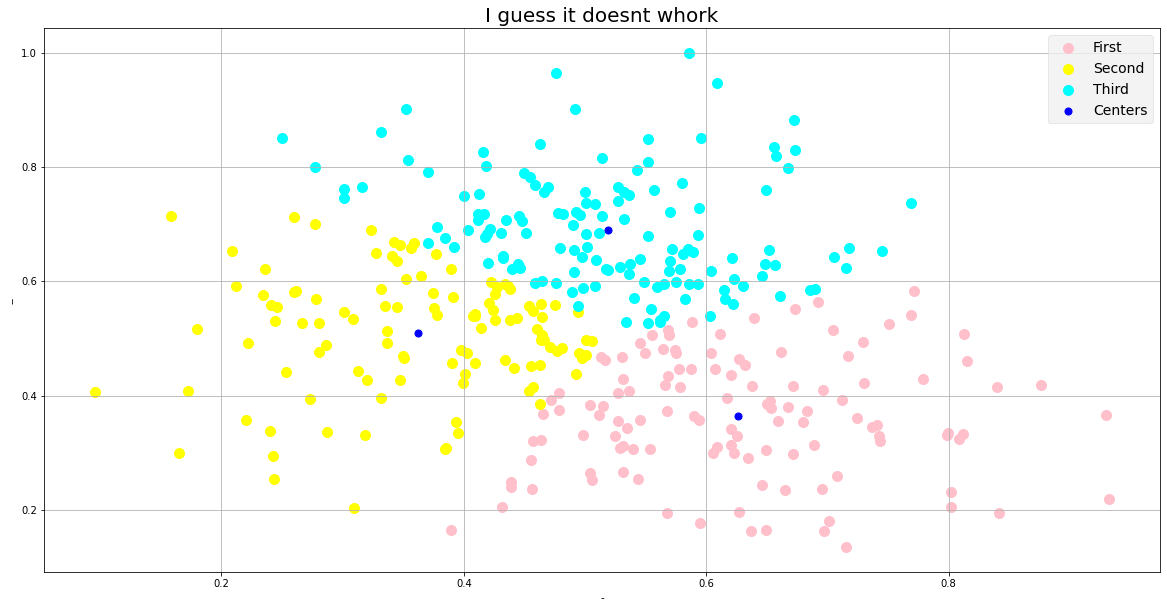

In [ ]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)
plt.rcParams['figure.figsize'] = (20, 10)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s=100, c='pink', label='First')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s=100, c='yellow', label='Second')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s=100, c='cyan', label='Third')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s=50, c='blue', label='Centers')

plt.style.use('fivethirtyeight')
plt.title('I guess it doesnt whork', fontsize = 20)
plt.xlabel('-')
plt.ylabel('--')
plt.legend()
plt.grid()
plt.show()

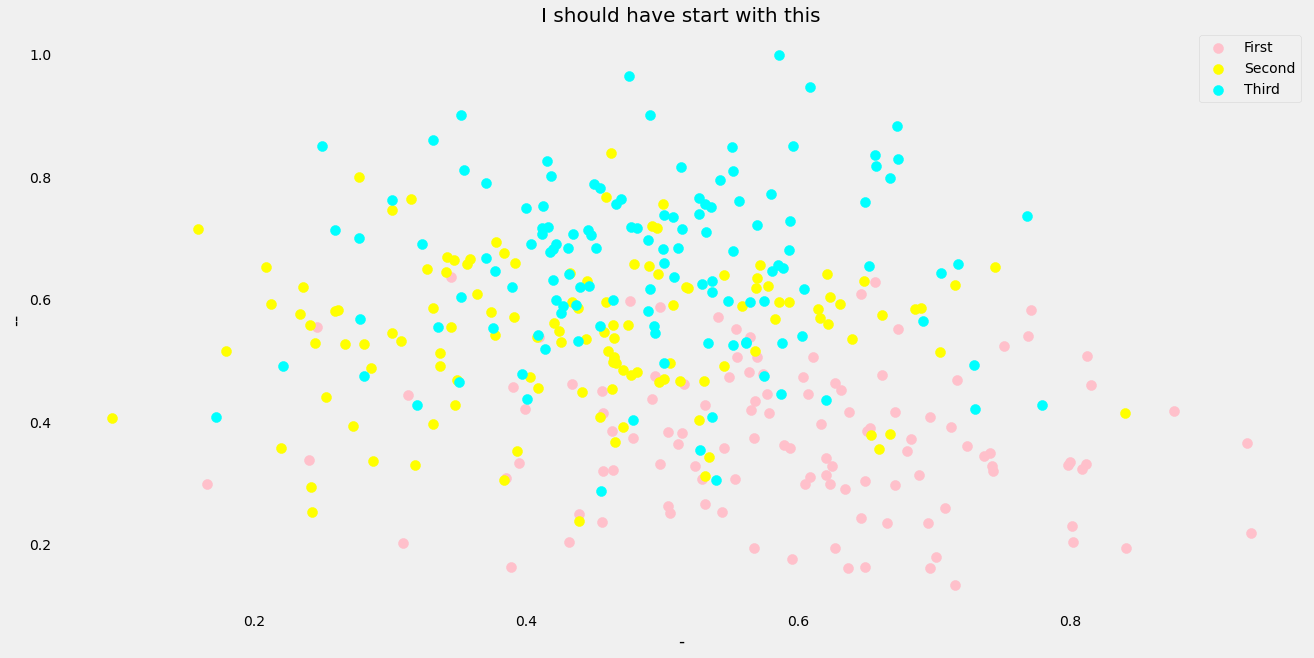

In [ ]:
plt.scatter(x[df['type'] == 'Ghost', 0], x[df['type'] == 'Ghost', 1], s=100, c='pink', label='First')
plt.scatter(x[df['type'] == 'Goblin', 0], x[df['type'] == 'Goblin', 1], s=100, c='yellow', label='Second')
plt.scatter(x[df['type'] == 'Ghoul', 0], x[df['type'] == 'Ghoul', 1], s=100, c='cyan', label='Third')

plt.style.use('fivethirtyeight')
plt.title('I should have start with this', fontsize = 20)
plt.xlabel('-')
plt.ylabel('--')
plt.legend()
plt.grid()
plt.show()

**Conclusion: data can not be divided into clusters as they strongly intersect, k-means will not work here**

##Training


In [ ]:
categorical_features = df.select_dtypes(include=["object"]).columns
numerical_features = df.select_dtypes(exclude=["object"]).columns
categorical_features = categorical_features.drop("type")

train_num = df[numerical_features]
train_cat = df[categorical_features]
# create dummy functions for categorical values
train_cat = pd.get_dummies(train_cat)

# combining categorical and numerical values
train = pd.concat([train_num, train_cat], axis = 1)
y = df['type']

# divide the data into test and training
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)

In [ ]:
model = svm.SVC()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

###Metrics (the percent of creatures that you correctly classify)

In [ ]:
#percentage
errors = (prediction != y_test)
percentage = np.sum(errors) * 100  / errors.size
percentage

65.17857142857143